In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
train_data=pd.read_csv("/content/fnn_train.csv")
test_data=pd.read_csv("/content/fnn_test.csv")
validation_data=pd.read_csv("/content/fnn_dev.csv")

#### Training data which consists of Fake and Real labels

In [5]:
train_data.head(3)

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,A national organization says Georgia has one o...,['http://www.ajc.com/news/georgia-politics-ele...,['A coalition of government watchdog groups la...,A coalition of government watchdog groups last...,fake
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,"Says Barack Obama's health care law ""will be t...",['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...,['As Supreme Court justices embarked on three ...,As Supreme Court justices embarked on three da...,fake
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,Says the Southwest Florida Water Management Di...,['http://www.tampabay.com/news/politics/gubern...,"[""Here's a new one: The Senate budget committe...",Here's a new one: The Senate budget committee ...,fake


In [6]:
test_data.head(3)

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1678,2010-04-11T16:37:40-04:00,Jon Kyl,"""President Obama himself attempted to filibust...",['http://abcnews.go.com/ThisWeek/video/supreme...,['U.S. Supreme Court Justice John Paul Stevens...,U.S. Supreme Court Justice John Paul Stevens a...,real
1,1820,2010-05-23T18:11:09-04:00,Michael Steele,"In Hawaii, ""they don't have a history of throw...",['http://www.starbulletin.com/news/bulletin/94...,"[""On ABC's This Week, the chairmen of the Repu...","On ABC's This Week, the chairmen of the Republ...",real
2,1624,2010-03-26T10:24:21-04:00,John Boehner,"""Our national debt ... is on track to exceed t...",['http://www.desmoinesregister.com/article/201...,['Ever since Barack Obama became president and...,Ever since Barack Obama became president and b...,real


In [7]:
validation_data.head(3)

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1636,2010-03-28T17:45:34-04:00,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",['http://blogs.tampabay.com/buzz/files/040307l...,['Gov. Charlie Crist launched what amounts to ...,Gov. Charlie Crist launched what amounts to a ...,fake
1,4352,2011-08-29T06:00:00-04:00,Bobby Scott,"""The estimated savings of this (debt ceiling) ...",['http://www.bobbyscott.house.gov/index.php?op...,"['U.S. Rep. Bobby Scott, D-3rd, was not please...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real
2,16471,2019-02-12T17:35:38-05:00,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",['https://www.wispolitics.com/2019/sen-fitzger...,"[""Amid reports questioning Foxconn Technology ...",Amid reports questioning Foxconn Technology Gr...,fake


In [8]:
train_data.isnull().sum()

id                         0
date                       0
speaker                    0
statement                  0
sources                    0
paragraph_based_content    0
fullText_based_content     0
label_fnn                  0
dtype: int64

#### text without a source doesnt seem promising and can affect the final results, therefore, I decided to remove the nan values which constitutes about '.2%' of the values which is negligible 

In [9]:
train_data.dropna(inplace=True)

####Cleaning

In [10]:
processed_features_list = []
def processed_feature_func(data, column):
    for sentence in range(0, len(data)):
    # Remove all the special characters
        processed_feature = re.sub(r'\W', ' ', str(train_data[column][sentence]))

        # remove all single characters
        processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

        # Remove single characters from the start
        processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

        # Substituting multiple spaces with single space
        processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

        # Removing prefixed 'b'
        processed_feature = re.sub(r'^b\s+', '', processed_feature)
        #making whole text lowercase
        # Converting to Lowercase
        processed_feature = processed_feature.lower()

        processed_features_list.append(processed_feature)

    return(processed_features_list)

In [11]:
train_data['fullText_based_content']=processed_feature_func(train_data, 'fullText_based_content')

In [12]:
processed_features_list = []
train_data['statement']=(processed_feature_func(train_data, 'statement'))

In [13]:
processed_features_list = []
train_data['paragraph_based_content'] = processed_feature_func(train_data, 'paragraph_based_content')

In [14]:
stop = stopwords.words('english')

#### removing stop words from the text

In [15]:
train_data['fullText_based_content'] = train_data['fullText_based_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_data['paragraph_based_content'] = train_data['paragraph_based_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_data['statement'] = train_data['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [16]:
train_data

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,national organization says georgia one america...,['http://www.ajc.com/news/georgia-politics-ele...,coalition government watchdog groups last week...,coalition government watchdog groups last week...,fake
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,says barack obama health care law biggest job ...,['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...,supreme court justices embarked three days ora...,supreme court justices embarked three days ora...,fake
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,says southwest florida water management distri...,['http://www.tampabay.com/news/politics/gubern...,new one senate budget committee chairman says ...,new one senate budget committee chairman says ...,fake
3,3450,2011-03-21T12:20:02-04:00,Paul Ryan,congressional budget office economic model mea...,['http://www.cnn.com/2011/POLITICS/03/17/gop.b...,recently house budget chairman paul ryan wis a...,recently house budget chairman paul ryan wis a...,real
4,4776,2011-11-13T07:30:00-05:00,Rodney Frelinghuysen,says treasury department says 41 percent busin...,['http://frelinghuysen.house.gov/index.cfm?sec...,millionaires tax proposal made latest appearan...,millionaires tax proposal made latest appearan...,fake
...,...,...,...,...,...,...,...,...
15207,7125,2012-11-28T16:57:04-05:00,John Cornyn,says veterans disability claims backlog double...,['https://twitter.com/johncornyn/status/270488...,legislation filed week sen john cornyn touts t...,legislation filed week sen john cornyn touts t...,real
15208,17742,2020-01-09T15:05:09-05:00,Bernie Sanders,2018 biden lauded paul ryan proposing cuts soc...,['https://bernie.substack.com/p/bern-notice-be...,sen bernie sanders argues former vice presiden...,sen bernie sanders argues former vice presiden...,fake
15209,16988,2019-06-18T12:06:24-04:00,Viral image,says michael bloomberg said known trump decade...,['https://www.facebook.com/liberalamerica.life...,ready billionaire talk recent facebook post la...,ready billionaire talk recent facebook post la...,fake
15210,5758,2012-04-18T09:00:00-04:00,AFSCME,labor negotiations city employees milwaukee ma...,['http://www.wseu-24.org/issue_barrett_tom_201...,know labor unions stand republican gov scott w...,know labor unions stand republican gov scott w...,fake


### Below code was taken from advertools in order to sort the url and achieve the target https://advertools.readthedocs.io/en/master/_modules/advertools/urlytics.html

In [17]:
from urllib.parse import urlsplit, parse_qs, unquote

import pandas as pd


def url_to_df(urls, decode=True):
    """Split the given URLs into their components to a DataFrame.

    Each column will have its own component, and query parameters and
    directories will also be parsed and given special columns each.

    :param url urls: A list of URLs to split into components
    :param bool decode: Whether or not to decode the given URLs
    :return DataFrame split: A DataFrame with a column for each component
    """
    if isinstance(urls, str):
        urls = [urls]
    decode = unquote if decode else lambda x: x
    split_list = []
    for url in urls:
        split = urlsplit(decode(url))
        port = split.port
        hostname = split.hostname if split.hostname != split.netloc else None
        split = split._asdict()
        if hostname:
            split['hostname'] = hostname
        if port:
            split['port'] = port
        parsed_query = parse_qs(split['query'])
        parsed_query = {'query_' + key: '@@'.join(val)
                        for key, val in parsed_query.items()}
        split.update(**parsed_query)
        dirs = split['path'].strip('/').split('/')
        if dirs[0]:
            dir_cols = {'dir_{}'.format(n): d for n, d in enumerate(dirs, 1)}
            split.update(**dir_cols)
        split_list.append(split)
    df = pd.DataFrame(split_list)

    query_df = df.filter(regex='query_')
    if not query_df.empty:
        df = df.drop(query_df.columns, axis=1)
    dirs_df = df.filter(regex='dir_')
    if not dirs_df.empty:
        df = df.drop(dirs_df.columns, axis=1)
    df = pd.concat([df, dirs_df, query_df], axis=1)
    df.insert(0, 'url', [decode(url) for url in urls])
    return df

In [18]:
url_to_df(train_data['sources'][1])

,url,scheme,netloc,path,query,fragment,dir_1,dir_2,dir_3,dir_4,query_v,query_feature
0,['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...,,,['http://www.youtube.com/watch,"v=TaC0mKApf9Q&feature=youtu.be', 'http://www.p...","fl', 'http://www.tampabay.com/blogs/the-buzz-f...",['http:,,www.youtube.com,watch,TaC0mKApf9Q,"youtu.be', 'http://www.politifact.com/truth-o-..."


In [19]:
url_df=url_to_df(train_data['sources'])

In [20]:
url_df['dir_3'].nunique()

3554

In [21]:
from collections import Counter
import collections

In [22]:
counts_directory=collections.Counter(url_df['dir_3'])

In [23]:
counts_directory.most_common(10)

[('www.youtube.com', 1537),
 ('www.facebook.com', 928),
 ('twitter.com', 721),
 ('www.politifact.com', 563),
 ('www.whitehouse.gov', 278),
 (nan, 273),
 ('docs.google.com', 269),
 ('abcnews.go.com', 194),
 ('www.washingtonpost.com', 188),
 ('www.c-span.org', 168)]

In [24]:
train_data['source']=url_df['dir_3']

In [25]:
train_data.drop('sources', inplace=True, axis=1)

In [26]:
train_data

,id,date,speaker,statement,paragraph_based_content,fullText_based_content,label_fnn,source
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,national organization says georgia one america...,coalition government watchdog groups last week...,coalition government watchdog groups last week...,fake,www.ajc.com
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,says barack obama health care law biggest job ...,supreme court justices embarked three days ora...,supreme court justices embarked three days ora...,fake,www.youtube.com
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,says southwest florida water management distri...,new one senate budget committee chairman says ...,new one senate budget committee chairman says ...,fake,www.tampabay.com
3,3450,2011-03-21T12:20:02-04:00,Paul Ryan,congressional budget office economic model mea...,recently house budget chairman paul ryan wis a...,recently house budget chairman paul ryan wis a...,real,www.cnn.com
4,4776,2011-11-13T07:30:00-05:00,Rodney Frelinghuysen,says treasury department says 41 percent busin...,millionaires tax proposal made latest appearan...,millionaires tax proposal made latest appearan...,fake,frelinghuysen.house.gov
...,...,...,...,...,...,...,...,...
15207,7125,2012-11-28T16:57:04-05:00,John Cornyn,says veterans disability claims backlog double...,legislation filed week sen john cornyn touts t...,legislation filed week sen john cornyn touts t...,real,twitter.com
15208,17742,2020-01-09T15:05:09-05:00,Bernie Sanders,2018 biden lauded paul ryan proposing cuts soc...,sen bernie sanders argues former vice presiden...,sen bernie sanders argues former vice presiden...,fake,bernie.substack.com
15209,16988,2019-06-18T12:06:24-04:00,Viral image,says michael bloomberg said known trump decade...,ready billionaire talk recent facebook post la...,ready billionaire talk recent facebook post la...,fake,www.facebook.com
15210,5758,2012-04-18T09:00:00-04:00,AFSCME,labor negotiations city employees milwaukee ma...,know labor unions stand republican gov scott w...,know labor unions stand republican gov scott w...,fake,www.wseu-24.org


In [27]:
df_url_counts = pd.DataFrame(counts_directory.most_common(20),
                             columns=['url', 'count'])

df_url_counts.head()

,url,count
0,www.youtube.com,1537
1,www.facebook.com,928
2,twitter.com,721
3,www.politifact.com,563
4,www.whitehouse.gov,278


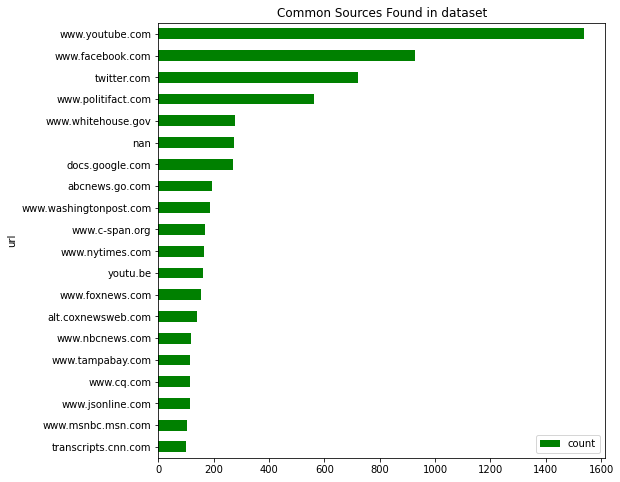

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df_url_counts.sort_values(by='count').plot.barh(x='url',
                      y='count',
                      ax=ax,
                      color="green")

ax.set_title("Common Sources Found in dataset")

plt.show()

In [29]:
from nltk.stem.wordnet import WordNetLemmatizer

In [30]:
lemmatizer = WordNetLemmatizer()

### Lemmatized text

In [31]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
   
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        elif len(word)>2:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [32]:
for sentence in range(len(train_data)):
    train_data['fullText_based_content'][sentence]=lemmatize_sentence(train_data['fullText_based_content'][sentence])
    train_data['paragraph_based_content'][sentence]=lemmatize_sentence(train_data['paragraph_based_content'][sentence])
    train_data['statement'][sentence]=lemmatize_sentence(train_data['statement'][sentence])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

In [33]:
train_data

,id,date,speaker,statement,paragraph_based_content,fullText_based_content,label_fnn,source
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,national organization say georgia one america ...,coalition government watchdog group last week ...,coalition government watchdog group last week ...,fake,www.ajc.com
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,say barack obama health care law big job kille...,supreme court justice embark three day oral ar...,supreme court justice embark three day oral ar...,fake,www.youtube.com
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,say southwest florida water management distric...,new one senate budget committee chairman say w...,new one senate budget committee chairman say w...,fake,www.tampabay.com
3,3450,2011-03-21T12:20:02-04:00,Paul Ryan,congressional budget office economic model mea...,recently house budget chairman paul ryan wi al...,recently house budget chairman paul ryan wi al...,real,www.cnn.com
4,4776,2011-11-13T07:30:00-05:00,Rodney Frelinghuysen,say treasury department say 41 percent busines...,millionaire tax proposal make late appearance ...,millionaire tax proposal make late appearance ...,fake,frelinghuysen.house.gov
...,...,...,...,...,...,...,...,...
15207,7125,2012-11-28T16:57:04-05:00,John Cornyn,say veteran disability claim backlog double ob...,legislation file week sen john cornyn tout tex...,legislation file week sen john cornyn tout tex...,real,twitter.com
15208,17742,2020-01-09T15:05:09-05:00,Bernie Sanders,2018 biden laud paul ryan propose cut social s...,sen bernie sander argue former vice president ...,sen bernie sander argue former vice president ...,fake,bernie.substack.com
15209,16988,2019-06-18T12:06:24-04:00,Viral image,say michael bloomberg say know trump decade tr...,ready billionaire talk recent facebook post la...,ready billionaire talk recent facebook post la...,fake,www.facebook.com
15210,5758,2012-04-18T09:00:00-04:00,AFSCME,labor negotiation city employee milwaukee mayo...,know labor union stand republican gov scott wa...,know labor union stand republican gov scott wa...,fake,www.wseu-24.org


In [34]:
words_in_dataset=[words.split() for words in train_data['statement']]

In [35]:
len(words_in_dataset)

15212

In [36]:
just_words=[]
for i in words_in_dataset:
  for j in i:
    just_words.append(j)

In [37]:
len(just_words)

172826

https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells

In [38]:
from matplotlib import rcParams
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [39]:
wordcloud = WordCloud(background_color="white", max_words=274).generate(str(just_words))

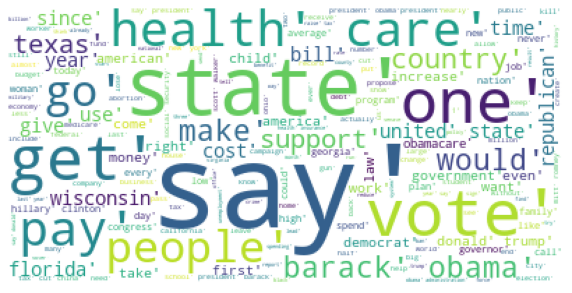

In [40]:
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [41]:
counts=collections.Counter(just_words)

In [42]:
counts.most_common(25)

[('say', 4903),
 ('state', 2002),
 ('year', 1781),
 ('percent', 1605),
 ('tax', 1497),
 ('obama', 1110),
 ('000', 1078),
 ('people', 1036),
 ('president', 1003),
 ('million', 957),
 ('job', 867),
 ('vote', 865),
 ('health', 858),
 ('one', 776),
 ('would', 755),
 ('care', 722),
 ('pay', 719),
 ('new', 717),
 ('american', 700),
 ('get', 693),
 ('time', 688),
 ('bill', 670),
 ('billion', 659),
 ('country', 650),
 ('1', 633)]

In [43]:
df_counts = pd.DataFrame(counts.most_common(25),
                             columns=['words', 'count'])

df_counts.head()

,words,count
0,say,4903
1,state,2002
2,year,1781
3,percent,1605
4,tax,1497


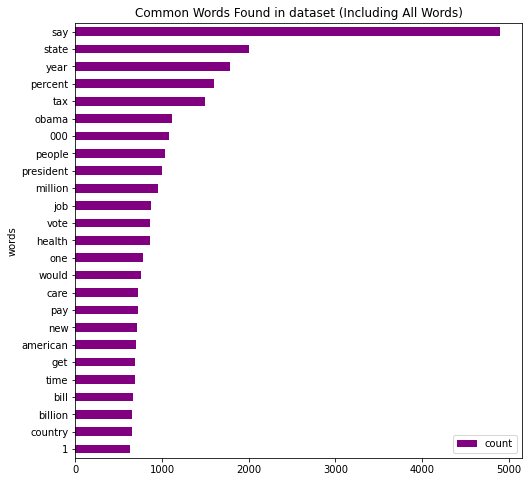

In [44]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df_counts.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in dataset (Including All Words)")

plt.show()

In [45]:
counts_label=collections.Counter(train_data['label_fnn'])

In [46]:
counts_label

Counter({'fake': 7621, 'real': 7591})

In [47]:
df_label_counts = pd.DataFrame(counts_label.most_common(2), columns=['label', 'count'])

df_label_counts.head()

,label,count
0,fake,7621
1,real,7591


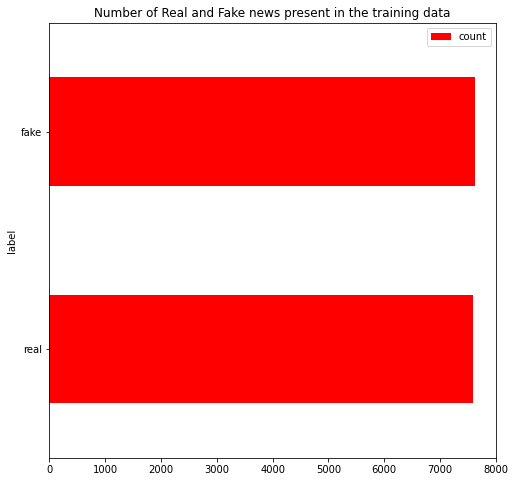

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
df_label_counts.sort_values(by='count').plot.barh(x='label',
                      y='count',
                      ax=ax,
                      color="red")

ax.set_title("Number of Real and Fake news present in the training data")

plt.show()

In [49]:
train_data.columns

Index(['id', 'date', 'speaker', 'statement', 'paragraph_based_content',
       'fullText_based_content', 'label_fnn', 'source'],
      dtype='object')

In [50]:
from textblob import TextBlob
import plotly.figure_factory as ff

https://plotly.com/python/figure-factory-subplots/

### Below cell is to test out the polarity of the text, the polarity is between the range [-1,1]. -1 being the worst and 1 being the best. According to analysis we can see that all the text are neutral. 

### X-axis shows the length of the articles, we can see that most of the articles are in the range of 0 to 1000 words.

In [50]:
train_data['polarity'] = train_data['fullText_based_content'].map(lambda text: TextBlob(text).sentiment.polarity)

def text_len(x):
    if type(x) is str:
        return len(x.split())
    else:
        return 0

train_data['length'] = train_data['fullText_based_content'].apply(text_len)
nums_text = train_data.query('length > 0')['length']

fig = ff.create_distplot(hist_data = [nums_text], group_labels = ['fullText_based_content'])
fig.update_layout(title_text='Distribution of article length', template="plotly_white")
fig.show()

In [52]:
import gensim

### performing topic modeling on first 100 sentences of the statement column of train_data dataset to check how the data is reacting.

In [59]:
for sentence in range(0, 100):
    corpus = lemmatize_sentence(train_data['statement'][sentence])
    #print(corpus)
    corpus = [corpus.split(' ')]
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                      num_topics = 4, 
                                      id2word = dic,                                    
                                      passes = 10,
                                      workers = 2)
lda_model.show_topics()

[(0,
  '0.100*"regulates" + 0.100*"2012" + 0.100*"1" + 0.100*"environmental" + 0.100*"jan" + 0.100*"protection" + 0.100*"regulation" + 0.100*"agency" + 0.100*"dust" + 0.100*"effect"'),
 (1,
  '0.100*"regulates" + 0.100*"regulation" + 0.100*"agency" + 0.100*"2012" + 0.100*"1" + 0.100*"environmental" + 0.100*"jan" + 0.100*"dust" + 0.100*"protection" + 0.100*"effect"'),
 (2,
  '0.100*"effect" + 0.100*"dust" + 0.100*"protection" + 0.100*"jan" + 0.100*"environmental" + 0.100*"regulation" + 0.100*"1" + 0.100*"agency" + 0.100*"2012" + 0.100*"regulates"'),
 (3,
  '0.100*"regulates" + 0.100*"2012" + 0.100*"agency" + 0.100*"environmental" + 0.100*"1" + 0.100*"effect" + 0.100*"jan" + 0.100*"regulation" + 0.100*"protection" + 0.100*"dust"')]